# Reading TFRecord files to tensors example

In [2]:
# !gcloud auth application-default login # Run this if you haven't already
!gcloud config set project simp-cs231n

Updated property [core/project].


In [31]:
import tensorflow as tf
import numpy as np
import dateutil

In [61]:
BUCKET = "cs231-firefighters"

POSITIVE_FOLDER = "us_wildfire_dataset/us_fires_landsat7_positive_labels"
NEGATIVE_FOLDER = "us_wildfire_dataset/us_fires_landsat7_negative_labels"

TRAIN_FILE_PREFIX = 'Training_us_fires'
file_extension = '.tfrecord.gz'

# These are the image channels that you want to extract
# These are specific to the satellite. Here, we use LANDSAT7
BANDS = ['B3', 'B2', 'B1']

# Here are the label properties associated with each image.
SCALARS = ["fire_index", "x_coord", "y_coord", "y"]
STRINGS = ["fpa_id", "img_date"]

# Specify inputs (Landsat bands) to the model and the response variable (to be implemented).
FEATURES = BANDS + SCALARS + STRINGS

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 128
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]

# Determine tf.Dataset batching
BATCH_SIZE = 64

In [62]:
try:
    if tf.io.gfile.exists("gs://" + BUCKET): print("Cloud bucket found!")
    else: print("Could not find bucket. Are you authenticated through gcloud?")
except Exception as e:
    print("Could not find bucket. Are you authenticated through gcloud?")
    print("%r" % e)

Cloud bucket found!


## Helper functions

These re-hydrate the raw TFRecord into a usable format (i.e. tf.Dataset and tf.Tensor)

In [63]:
# These helper functions adopted from ex TF/GEE workflow notebook
def parse_tfrecord(example_proto):
    return tf.io.parse_single_example(example_proto, FEATURES_DICT)

def format_tensor_and_scalars(inputs):
    # convert BANDS to 3d tensors
    inputsList = [inputs.get(key) for key in BANDS]
    stacked = tf.stack(inputsList, axis=0)
    # Convert from CHW to HWC
    stacked = tf.transpose(stacked, [1, 2, 0])
    band_tensor = stacked
    # convert SCALARS to dictionary of rank-1 tensors
    scalars_dict = {thisKey : inputs[thisKey] for thisKey in SCALARS + STRINGS}
    return band_tensor, scalars_dict 


def get_dataset(pattern):
    glob = tf.io.gfile.glob(pattern)
    dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
    dataset = dataset.map(format_tensor_and_scalars, num_parallel_calls=5)
    return dataset


def get_positive_labels():
	glob = 'gs://' + BUCKET + '/' + POSITIVE_FOLDER + '/' + TRAIN_FILE_PREFIX + '*'
	dataset = get_dataset(glob)
	dataset = dataset.batch(BATCH_SIZE)
	return dataset

def get_negative_labels():
	glob = 'gs://' + BUCKET + '/' + NEGATIVE_FOLDER + '/' + TRAIN_FILE_PREFIX + '*'
	dataset = get_dataset(glob)
	dataset = dataset.batch(BATCH_SIZE)
	return dataset

In [64]:
# explicitly define data types to expect
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32, default_value=tf.zeros(KERNEL_SHAPE)) for k in BANDS
]
COLUMNS += [
  tf.io.FixedLenFeature(shape=1, dtype=tf.float32) for k in SCALARS       
]
COLUMNS += [
  tf.io.FixedLenFeature(shape=1, dtype=tf.string) for k in STRINGS       
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

In [65]:
positive_dataset = get_positive_labels()
negative_dataset = get_negative_labels()

In [66]:
import matplotlib.pyplot as plt

# Let's see some examples
x1, y1 = iter(positive_dataset.take(1)).next()
x2, y2 = iter(negative_dataset.take(1)).next()

# Shape info
print("x (B, H, W, C): ", x1.shape)
print("y :", y1.keys())

x (B, H, W, C):  (64, 128, 128, 3)
y : dict_keys(['fire_index', 'x_coord', 'y_coord', 'y', 'fpa_id', 'img_date'])


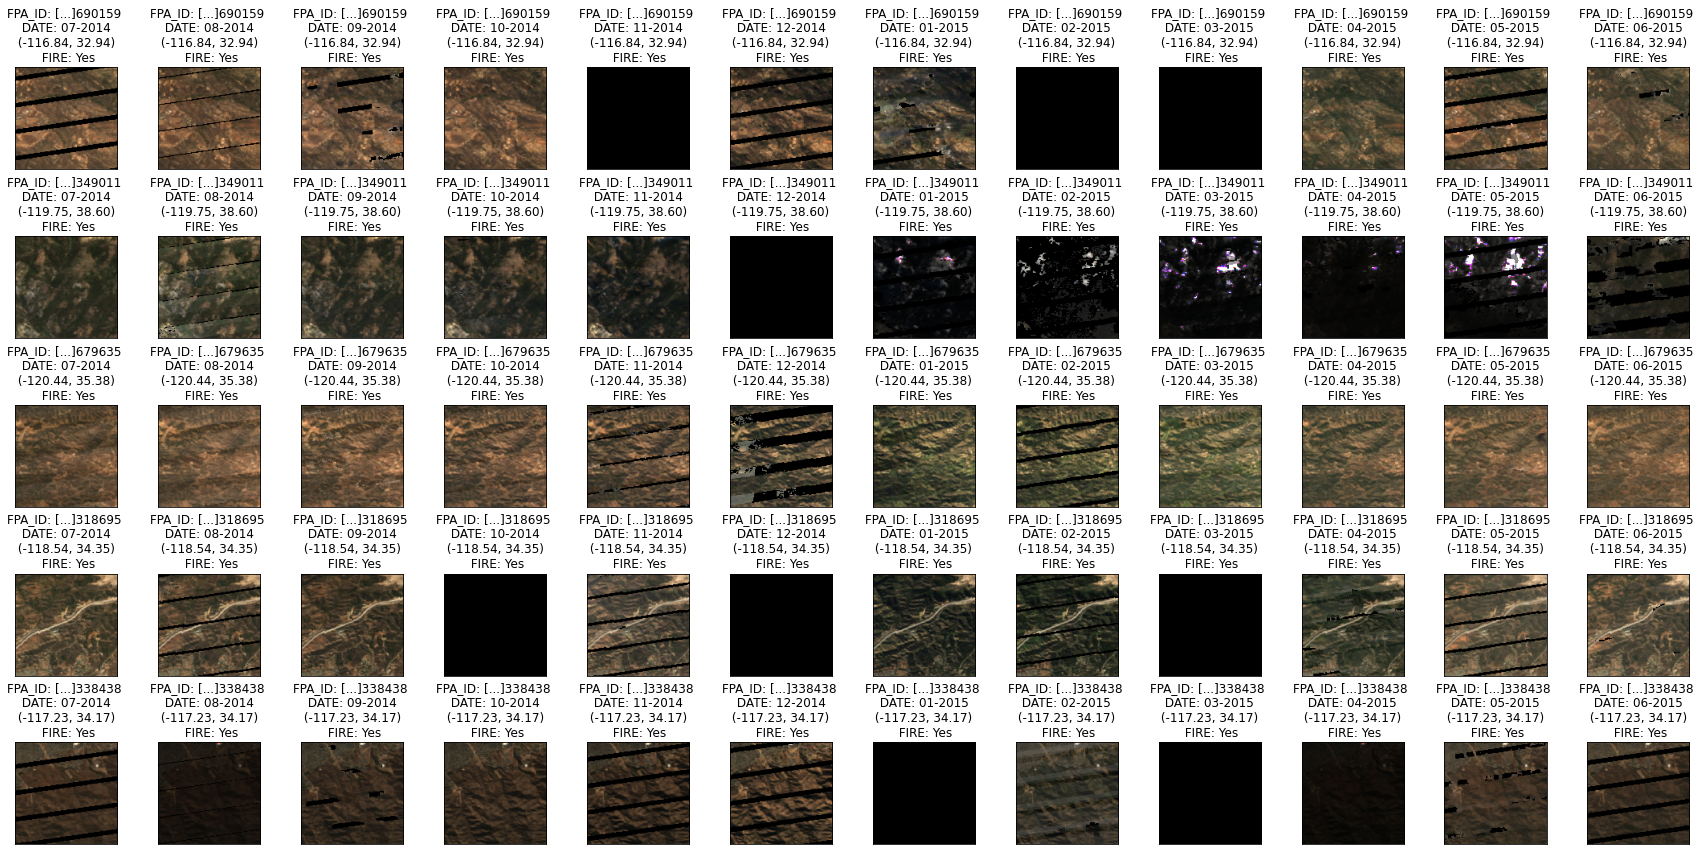

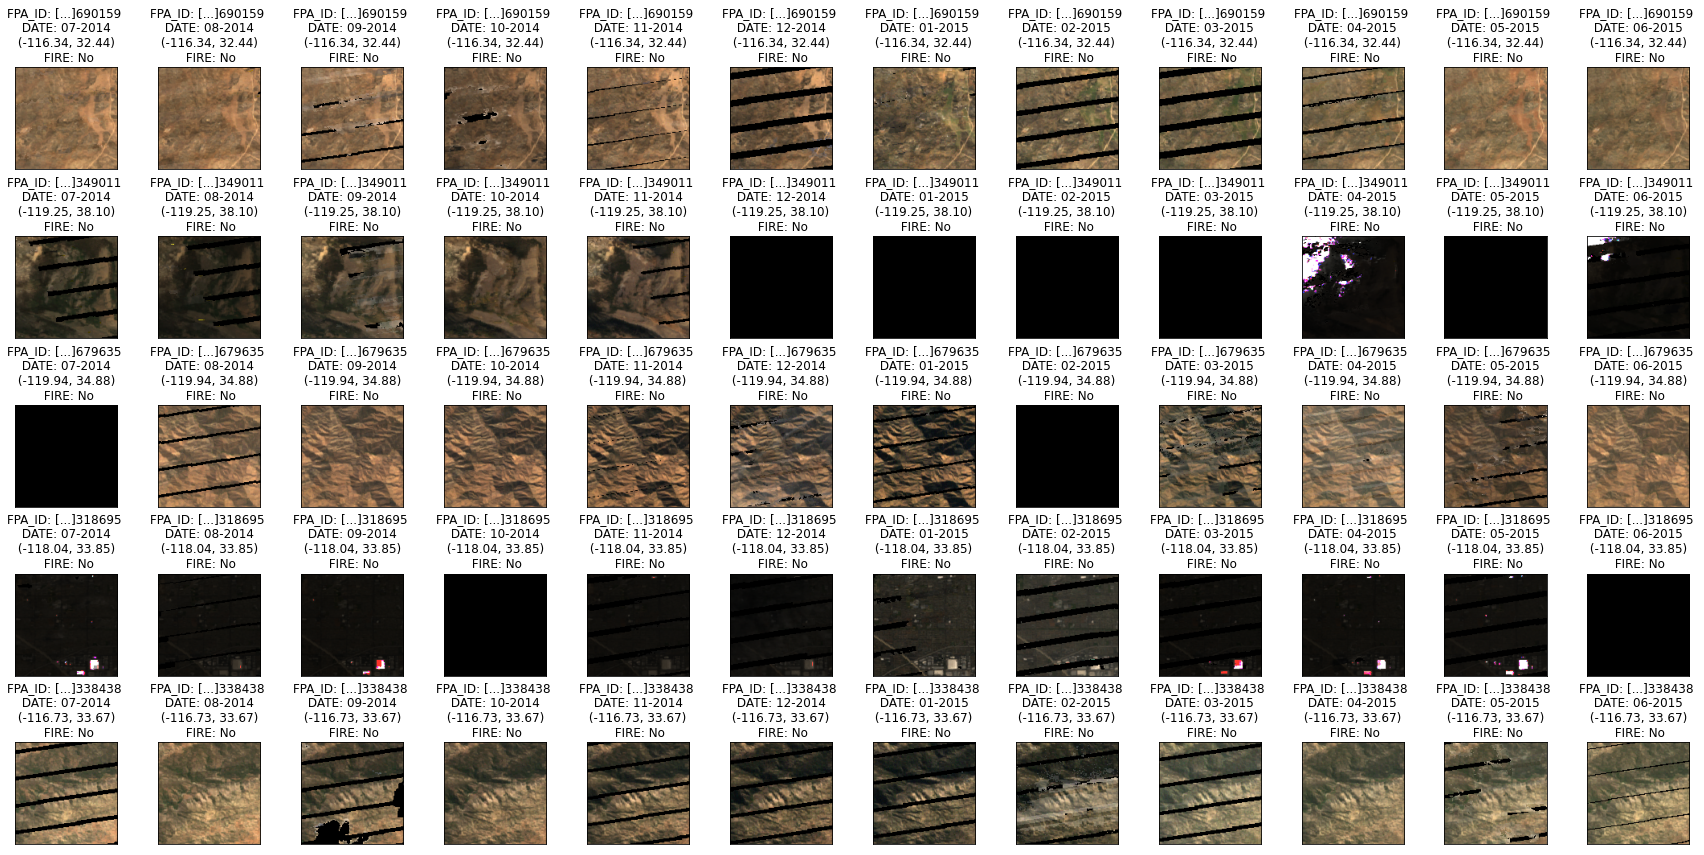

In [69]:
# Visualize

def example_plot(x, y, plot_batch=2, time_series=12):
    fig, axs = plt.subplots(plot_batch, time_series, figsize=(30, 3*plot_batch))
    c = 0  # counter index
    x = x.numpy()
    for i in range(plot_batch):
        for j in range(12):
            img = x[c] / np.max(x[c])
            img[np.isnan(img)] = 0
            axs[i][j].imshow(np.abs(img))
            title = "FPA_ID: [...]{} \n DATE: {} \n ({:.2f}, {:.2f}) \n FIRE: {}"\
                    .format(y["fpa_id"].numpy()[c][0].decode('utf-8')[-6:],
                            dateutil.parser.parse(y["img_date"].numpy()[c][0].decode('utf-8')).strftime("%m-%Y"),
                            y["x_coord"].numpy()[c][0],
                            y["y_coord"].numpy()[c][0],
                            "Yes" if y["y"].numpy()[c][0] == 1 else "No")
            axs[i][j].set_title(title)
            axs[i][j].set_xticks([])
            axs[i][j].set_yticks([])
            c += 1
    plt.subplots_adjust(wspace=0.4)
    plt.show()

example_plot(x1, y1, plot_batch=5)
example_plot(x2, y2, plot_batch=5)